In [9]:
import mitsuba as mi

mi.set_variant("cuda_ad_rgb")
import drjit as dr
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np

import os
import sys
ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

from utils.rough_scene import (
    ENVLIGHT_KEY,
    ROUGH_KEY,
    Scene,
    generate_rand_envlight,
    generate_rand_init_values,
    generate_rand_rough_tex,
    plot_rough_envlight,
    plot_rough_envlight2,
    reset_scene,
    reset_func,
    get_full_zeros_params,
    get_full_ones_params,
    run_opt_set_init,
    plot_opt_results,
    upsample,
)
from utils.utils import image_to_bm, to_float, unidim_to_bm, rel_l1_loss, mse, LOSS_FNS
from utils.plot import (
    plot_loss_linear_interp_1d,
    plot_loss_bilinear_interp_2d,
    plot_losses,
)

mi.Thread.thread().logger().set_log_level(mi.LogLevel.Error)

# Reference scenes rendering

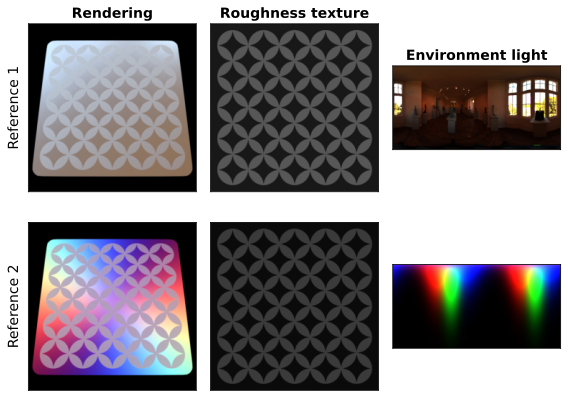

In [10]:
scene_ref = {k: reset_scene(k) for k in Scene}
params = {k: mi.traverse(scene_ref[k]) for k in Scene}

# Render reference images
image_ref = {k: mi.render(scene_ref[k], seed=0, spp=1024) for k in Scene}
params_rough_ref = {k: params[k][ROUGH_KEY] for k in Scene}
params_envlight_ref = {k: params[k][ENVLIGHT_KEY] for k in Scene}

image_ref_bm = {k: image_to_bm(image_ref[k])  for k in Scene}
params_rough_ref_bm = {k: unidim_to_bm(params_rough_ref[k])  for k in Scene}
params_envlight_ref_bm = {k: unidim_to_bm(params_envlight_ref[k])  for k in Scene}

refs = {k: {
    "img": image_ref_bm[k],
    "params_rough": params_rough_ref_bm[k],
    "params_envlight": params_envlight_ref_bm[k],
} for k in Scene}

def get_ref_params(scene_id):
    return {
        ROUGH_KEY: params_rough_ref[scene_id],
        ENVLIGHT_KEY: params_envlight_ref[scene_id],
    }

# Plot
plot_rough_envlight2({f'Reference {k.value}': (image_ref_bm[k], params_rough_ref_bm[k], params_envlight_ref_bm[k]) for k in Scene})

In [11]:
spp_primal = 128
spp = spp_primal
spp_grad = 32

In [12]:
# get reference losses
scene_s1 = reset_scene(Scene.COND1)
image_s1 = mi.render(scene_s1, mi.traverse(scene_s1), seed=0, spp=spp_primal, spp_grad=spp_grad)
ref_loss_s1 = {k: to_float(LOSS_FNS[k](image_s1, image_ref[Scene.COND1])) for k in LOSS_FNS}

scene_s2 = reset_scene(Scene.COND2)
image_s2 = mi.render(scene_s2, mi.traverse(scene_s2), seed=0, spp=spp_primal, spp_grad=spp_grad)
ref_loss_s2 = {k: to_float(LOSS_FNS[k](image_s2, image_ref[Scene.COND2])) for k in LOSS_FNS}

In [13]:
ref_loss_s1

{'Relative L1': 0.029033904895186424, 'MSE': 0.00039913944783620536}

In [14]:
def run_opt_set_init(
    scene_name: Scene,
    init_values,
    optimizer_name="adam",
    lr=1e-2,
    loss_fn=mse,
    n_iterations=10,
    spp_primal=16,
    spp_grad=4,
):
    # Optimization parameters
    optimizer_name = optimizer_name.lower().strip()

    losses = []
    image_init = []
    image_bm_init = []
    image_end = []
    image_bm_end = []
    tex_bm_init = []
    tex_bm_end = []
    params_end = []

    nb_opt_samples = len(init_values)

    for (opt_sample, initial_values) in enumerate(init_values):
        # Load scene
        scene = reset_scene(scene_name)

        params = mi.traverse(scene)
        params[ROUGH_KEY] = initial_values
        params.update()

        if optimizer_name == "sgd":
            opt = mi.ad.optimizers.SGD(lr=lr)
        elif optimizer_name == "adam":
            opt = mi.ad.optimizers.Adam(lr=lr)
        else:
            raise ValueError(f"Unknown optimizer {optimizer_name}")

        opt[ROUGH_KEY] = params[ROUGH_KEY]
        params.update(opt)

        losses.append([])
        for it in range(1,n_iterations+1):
            image = mi.render(
                scene,
                params,
                seed=it * nb_opt_samples + opt_sample,
                spp=spp_primal,
                spp_grad=spp_grad,
            )

            if it == 1:
                image_init.append(image)
                image_bm_init.append(image_to_bm(image))
                tex_bm_init.append(unidim_to_bm(params[ROUGH_KEY]))
            
            # Apply loss function
            loss = loss_fn(image, image_ref[scene_name])

            # Backpropagate
            dr.backward(loss)

            # Optimizer: take a gradient step
            opt.step()
            opt[ROUGH_KEY] = dr.clamp(opt[ROUGH_KEY], 1e-2, 1.0)

            # Optimizer: Update the scene parameters
            params.update(opt)

            if it == n_iterations:
                image_end.append(image)
                image_bm_end.append(image_to_bm(image))
                tex_bm_end.append(unidim_to_bm(params[ROUGH_KEY]))
                params_end.append(params[ROUGH_KEY])

            print(
                f"[Sample {opt_sample+1}/{nb_opt_samples}]  Iteration {it:03d}: loss={loss[0]:.5f}",
                end="\r",
            )
            losses[opt_sample].append(loss[0])
        print()
        
    return {
        "losses": losses,
        "image_init": image_init,
        "image_bm_init": image_bm_init,
        "image_end": image_end,
        "image_bm_end": image_bm_end,
        "tex_bm_init": tex_bm_init,
        "tex_bm_end": tex_bm_end,
        "params_end": params_end,
    }


In [15]:
def plot(
    images_bm, tex_bm, size_factor=3
):
    fig, ax = plt.subplots(
        ncols=2,
        nrows=len(images_bm),
        figsize=(8, size_factor * len(images_bm)),
        squeeze=False,
    )
    for i, (img, tex) in enumerate(
        zip(images_bm, tex_bm)
    ):
        ax[i, 0].imshow(img, vmin=0, vmax=1)
        ax[i, 1].imshow(tex, vmin=0, vmax=1)
        ax[i, 0].set_xticks([])
        ax[i, 0].set_yticks([])
        ax[i, 1].set_xticks([])
        ax[i, 1].set_yticks([])
    ax[0, 0].set_title("Rendering", weight="bold", size=14)
    ax[0, 1].set_title("Roughness texture", weight="bold", size=14)
    plt.tight_layout()
    plt.show()

# Long optimization

In [16]:
values = [generate_rand_rough_tex(Scene.COND1) for i in range(1)]
res = run_opt_set_init(Scene.COND1, values, optimizer_name="adam", lr=2e-3, loss_fn=mse, n_iterations=1000, spp_primal=spp_primal, spp_grad=spp_grad)

[Sample 1/1]  Iteration 1000: loss=0.00042


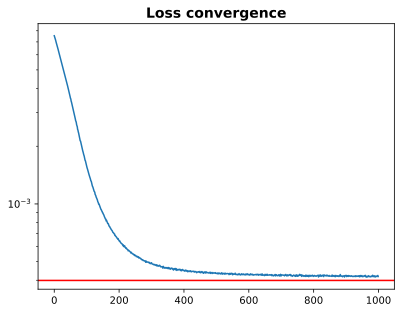

In [17]:
plot_losses(res["losses"], baseline=ref_loss_s1["MSE"])

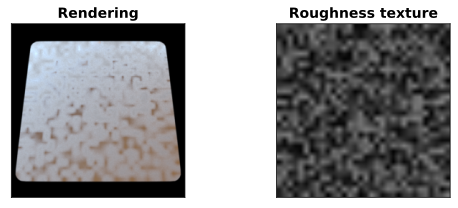

In [18]:
plot(res["image_bm_init"], res["tex_bm_init"], size_factor=3)

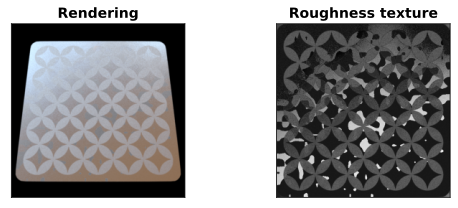

In [19]:
plot(res["image_bm_end"], res["tex_bm_end"], size_factor=3)

In [20]:
image_to_bm(image_ref[Scene.COND1])

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [21]:
image_to_bm(image_s1)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [22]:
unidim_to_bm(np.sum((res["image_end"][0] - image_ref[Scene.COND1])**2, axis=2))

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 0,
  struct = Struct<3>[
    uint8 R; // @0, normalized, premultiplied alpha
    uint8 G; // @1, normalized, premultiplied alpha
    uint8 B; // @2, normalized, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [23]:
unidim_to_bm(np.sum((image_s1 - image_ref[Scene.COND1])**2, axis=2))

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 0,
  struct = Struct<3>[
    uint8 R; // @0, normalized, premultiplied alpha
    uint8 G; // @1, normalized, premultiplied alpha
    uint8 B; // @2, normalized, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

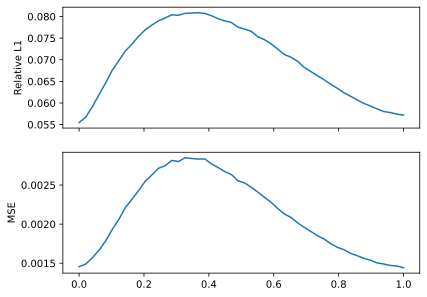

In [24]:
params_1 = {ROUGH_KEY: params_rough_ref[Scene.COND1]}
params_2 = {ROUGH_KEY: res["params_end"][0]}
plot_loss_linear_interp_1d(image_ref[Scene.COND1], params_1, params_2, reset_scene_func=lambda: reset_scene(Scene.COND1))

# Multiple optimization runs

In [33]:
nb_samples = 3
values = [generate_rand_rough_tex(Scene.COND1, seed=i) for i in range(nb_samples)]
res = run_opt_set_init(Scene.COND1, values, optimizer_name="adam", lr=1e-2, loss_fn=mse, n_iterations=200, spp_primal=spp_primal, spp_grad=spp_grad)

[Sample 1/3]  Iteration 200: loss=0.00044
[Sample 2/3]  Iteration 200: loss=0.00044
[Sample 3/3]  Iteration 200: loss=0.00045


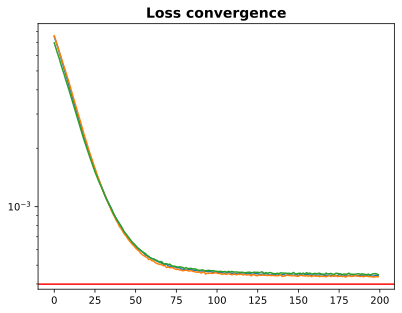

In [34]:
plot_losses(res["losses"], baseline=ref_loss_s1["MSE"])

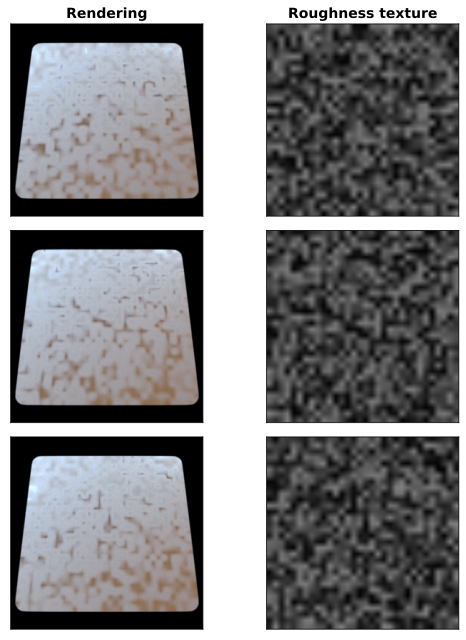

In [35]:
plot(res["image_bm_init"], res["tex_bm_init"], size_factor=3)

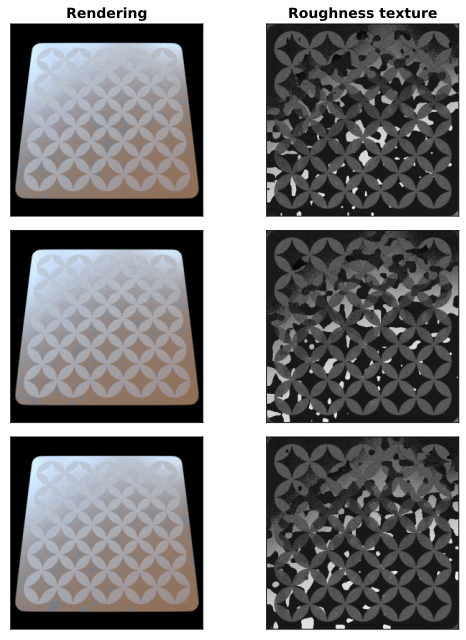

In [36]:
plot(res["image_bm_end"], res["tex_bm_end"], size_factor=3)

## Plot loss between converged solutions

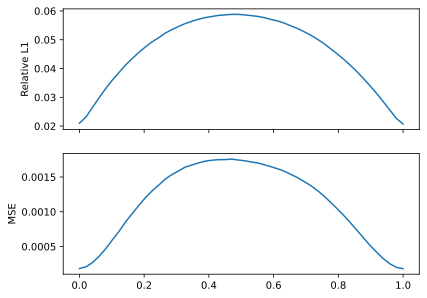

In [37]:
params_1 = {ROUGH_KEY: res["params_end"][0]}
params_2 = {ROUGH_KEY: res["params_end"][1]}
plot_loss_linear_interp_1d(image_ref[Scene.COND1], params_1, params_2, reset_scene_func=lambda: reset_scene(Scene.COND1))

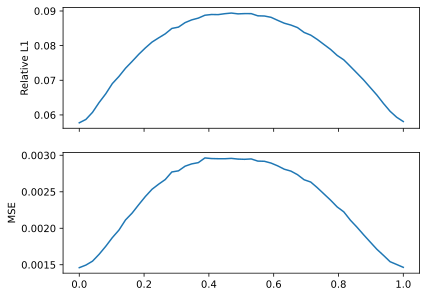

In [38]:
params_1 = {ROUGH_KEY: res["params_end"][0]}
params_2 = {ROUGH_KEY: res["params_end"][2]}
plot_loss_linear_interp_1d(image_ref[Scene.COND1], params_1, params_2, reset_scene_func=lambda: reset_scene(Scene.COND1))

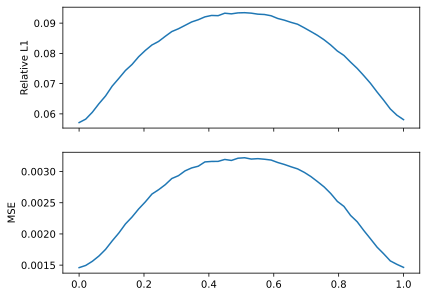

In [39]:
params_1 = {ROUGH_KEY: res["params_end"][1]}
params_2 = {ROUGH_KEY: res["params_end"][2]}
plot_loss_linear_interp_1d(image_ref[Scene.COND1], params_1, params_2, reset_scene_func=lambda: reset_scene(Scene.COND1))